### Libraries

In [163]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from copy import deepcopy

In [2]:
connection_args = {
    'host': '18.191.175.185', # You'll have to update this to your IP
    'user': 'ubuntu',    # username
    'dbname': 'mcnulty',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}
connection = pg.connect(**connection_args)
cursor = connection.cursor()

### Create Tables

Autopopulate the create table query with the proper column names and column types from the table schema file:

In [ ]:
with open('./Data/gw_tblschema.csv', mode = 'r') as filename:
    cols = filename.read()
    filename.close()
    
cols_list = [i.split(',')[1:3] for i in cols.split('\n')[1:-1]]
cols_text = ''
for i, txt in enumerate(cols_list):
    name = txt[0]
    col_type = txt[1]
    if col_type == 'STRING':
        col_type = 'TEXT'
    elif col_type == 'INTEGER':
        col_type = 'INT'
        
    if i == len(cols_list) - 1:
        cols_text += f'{name} {col_type}'
    else:
        cols_text += f'{name} {col_type}, '

Create baseball and gamepostwide tables in the SQL server:

In [ ]:
create_tblquery = f""" 
    CREATE TABLE baseball(
        row INT, 
        {cols_text}
    );"""

create_postwidetablequery = f""" 
    CREATE TABLE gamepostwide(
        row INT, 
        {cols_text}
    );"""

# cursor.execute('BEGIN;')
# cursor.execute(create_tblquery)
# cursor.execute(create_postwidetablequery)
# cursor.execute('commit;')

Create steal view for baseball table

In [213]:
steal_columns = ['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
            'venueoutfielddistances', 'inningnumber', 'inninghalf', 'inninghalfeventsequencenumber',
            'hitterbathand', 'pitcherid', 'pitcherthrowhand', 'pitchtype', 'pitchtypedescription',
            'pitchspeed', 'pitchzone', 'pitcherpitchcount', 'hitterpitchcount', 'balls',
          'strikes', 'outs', 'homecurrenttotalruns', 'awaycurrenttotalruns',
          'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid', 'rob1_outcomedescription',
          'rob2_start', 'rob2_end', 'rob2_isout', 'rob2_outcomeid', 'rob2_outcomedescription',
          'rob3_start', 'rob3_end', 'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription',
          'is_bunt', 'is_bunt_shown', 'is_double_play', 'is_triple_play', 'is_wild_pitch']
steal_columns_str = str(steal_columns).replace('[','').replace(']', '').replace("'", '')

create_stealview = f"""
    CREATE VIEW steals AS
    (SELECT {steal_columns_str}
    FROM baseball
    WHERE rob1_outcomeid LIKE '%CS%'
    OR rob1_outcomeid LIKE '%SB%'
    OR rob2_outcomeid LIKE '%CS%'
    OR rob2_outcomeid LIKE '%SB%'
    OR rob3_outcomeid LIKE '%CS%'
    OR rob3_outcomeid LIKE '%SB%'
    ORDER BY gameid, starttime, inningnumber, inninghalfeventsequencenumber);
"""

# cursor.execute('BEGIN;')
# cursor.execute(create_stealview)
# cursor.execute('commit;')


### EDA

In [ ]:
cursor.execute('BEGIN;')
cursor.close()
connection.close()

Below command does not work to find all steals, instead had to look at 'rob_outcomeid' for keywords 'CS' and 'SB'. Ended up creating a steals view incorporating that.

In [ ]:
query = """
    SELECT description
    FROM baseball
    WHERE description LIKE '%steal%'
    GROUP BY gameid, description
"""

### Model Building 

In [3]:
steal_query = """
    SELECT *
    FROM steals ;
"""
steal_df = pd_sql.read_sql(steal_query, connection)
steal_df['all_outcomes'] = (steal_df[['rob1_outcomeid', 'rob2_outcomeid', 'rob3_outcomeid']]
 .fillna('')
 .apply(lambda x: ''.join(x), axis = 1))

# plan to drop any caught stealing rows where pickoffs happen
steal_df['is_pickoff'] = steal_df['all_outcomes'].apply(lambda x: 1 if x.find('PO') >= 0 else 0)
steal_df = steal_df.where(steal_df['is_pickoff'] == 0).dropna(how = 'all')
steal_df.drop(columns = 'is_pickoff', inplace = True)

# if both stolen base and caught stealing happen at the same time, will count toward stolen base
steal_df['is_steal'] = steal_df['all_outcomes'].apply(lambda x: 1 if x.find('SB') >= 0 else 0)

In [283]:
steal_df.columns

Index(['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
       'venueoutfielddistances', 'inningnumber', 'inninghalf',
       'inninghalfeventsequencenumber', 'hitterbathand', 'pitcherid',
       'pitcherthrowhand', 'pitchtype', 'pitchtypedescription', 'pitchspeed',
       'pitchzone', 'pitcherpitchcount', 'hitterpitchcount', 'balls',
       'strikes', 'outs', 'homecurrenttotalruns', 'awaycurrenttotalruns',
       'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid',
       'rob1_outcomedescription', 'rob2_start', 'rob2_end', 'rob2_isout',
       'rob2_outcomeid', 'rob2_outcomedescription', 'rob3_start', 'rob3_end',
       'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription', 'is_bunt',
       'is_bunt_shown', 'is_double_play', 'is_triple_play', 'is_wild_pitch',
       'all_outcomes', 'is_steal'],
      dtype='object')

In [136]:
y = steal_df['is_steal']
X = steal_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
df = pd.concat([X_train, y_train], axis = 1)

In [137]:
df['is_day'] = df['daynight'].apply(lambda x: 1 if x == 'N' else 0)
df['is_grass'] = df['venuesurface'].apply(lambda x: 1 if x == 'grass' else 0)
df['is_home'] = df['inninghalf'].apply(lambda x: 1 if x == 'BOT' else 0)
df['is_batterR'] = df['hitterbathand'].apply(lambda x: 1 if x == 'R' else 0)
df['is_batterL'] = df['hitterbathand'].apply(lambda x: 1 if x == 'L' else 0)
df['is_pitcherR'] = df['pitcherthrowhand'].apply(lambda x: 1 if x == 'R' else 0)
df['all_onbase'] = df[['rob1_end', 'rob2_end', 'rob3_end']].apply(lambda x: tuple(x), axis = 1)
df['is_rob1'] = df['all_onbase'].apply(lambda x: 1 if x[0] > 1 else 0)
df['is_rob2'] = df['all_onbase'].apply(lambda x: 1 if x[0] > 2 else 0)
df['is_rob3'] = df['all_onbase'].apply(lambda x: 1 if x[0] > 3 else 0)

# Going to put forkball in other
print(df.pitchtypedescription.value_counts())
pitch_types = ['FA', 'SL', 'CU', 'CH', 'SI', 'CT', 'SP', 'PI']
for pt in pitch_types:
    df[f'is_{pt}'] = df['pitchtype'].apply(lambda x: 1 if x == pt else 0)
    
drop_cols = ['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
            'venueoutfielddistances', 'inninghalf', 'inninghalfeventsequencenumber', 'hitterbathand',
            'pitcherid', 'pitcherthrowhand', 'pitchtype', 'pitchtypedescription',
            'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid', 'rob1_outcomedescription',
            'rob2_start', 'rob2_end', 'rob2_isout', 'rob2_outcomeid', 'rob2_outcomedescription',
            'rob3_start', 'rob3_end', 'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription',
            'all_outcomes', 'all_onbase', 'is_steal']

df.drop(columns = drop_cols, inplace = True)
df.head()

Fastball       1097
Slider          378
Curveball       266
Changeup        232
Sinker          148
Cutter          105
Splitter         42
Pitchout         24
Knuckleball       6
Other             1
Name: pitchtypedescription, dtype: int64


,inningnumber,pitchspeed,pitchzone,pitcherpitchcount,hitterpitchcount,balls,strikes,outs,homecurrenttotalruns,awaycurrenttotalruns,...,is_rob2,is_rob3,is_FA,is_SL,is_CU,is_CH,is_SI,is_CT,is_SP,is_PI
3455,6.0,82.0,10.0,5.0,4.0,2.0,2.0,1.0,3.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1216,8.0,96.0,10.0,5.0,1.0,1.0,0.0,2.0,2.0,0.0,...,0,0,1,0,0,0,0,0,0,0
824,2.0,79.0,10.0,24.0,3.0,2.0,1.0,2.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
274,5.0,92.0,12.0,81.0,2.0,2.0,0.0,1.0,0.0,2.0,...,0,0,1,0,0,0,0,0,0,0
3541,1.0,89.0,11.0,19.0,3.0,1.0,2.0,3.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1


#### Baseline
Create baseline model where accuracy is compared to if model just guessed a successful base steal everytime.

In [139]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(df)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = df.columns)
X_train_scaled.head()

,inningnumber,pitchspeed,pitchzone,pitcherpitchcount,hitterpitchcount,balls,strikes,outs,homecurrenttotalruns,awaycurrenttotalruns,...,is_rob2,is_rob3,is_FA,is_SL,is_CU,is_CH,is_SI,is_CT,is_SP,is_PI
0,0.497138,-0.186822,0.132077,-1.032638,0.626514,0.551725,0.748792,-0.582528,0.476592,-0.459862,...,-0.202825,-0.029007,-0.925037,-0.434633,2.818441,-0.328721,-0.257562,-0.214882,-0.134059,-0.100951
1,1.251647,0.632438,0.132077,-1.032638,-1.011373,-0.471310,-1.415699,0.565636,0.001995,-0.940114,...,-0.202825,-0.029007,1.081037,-0.434633,-0.354806,-0.328721,-0.257562,-0.214882,-0.134059,-0.100951
2,-1.011879,-0.362377,0.132077,-0.366510,0.080552,0.551725,-0.333454,0.565636,-0.947199,-0.940114,...,-0.202825,-0.029007,-0.925037,-0.434633,2.818441,-0.328721,-0.257562,-0.214882,-0.134059,-0.100951
3,0.119884,0.398364,0.685753,1.631875,-0.465411,0.551725,-1.415699,-0.582528,-0.947199,0.020389,...,-0.202825,-0.029007,1.081037,-0.434633,-0.354806,-0.328721,-0.257562,-0.214882,-0.134059,-0.100951
4,-1.389133,0.222808,0.408915,-0.541807,0.080552,-0.471310,0.748792,1.713801,0.001995,-0.940114,...,-0.202825,-0.029007,-0.925037,-0.434633,-0.354806,-0.328721,-0.257562,-0.214882,-0.134059,9.905806


In [176]:
DC = DummyClassifier(random_state = 42)
DC.fit(X_train_scaled, y_train)
dummy_predict = DC.predict(X_train_scaled)
dummy_acc = np.round(accuracy_score(y_train, dummy_predict), 4)
dummy_pre = np.round(precision_score(y_train, dummy_predict), 4)
print(f'The baseline accuracy is: {dummy_acc}')
print(f'The baseline precision is: {dummy_pre}')

The baseline accuracy is: 0.6196
The baseline precision is: 0.7419


In [140]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train_scaled, y_train)
y_predict = LR.predict(X_train_scaled)
y_predictprob = LR.predict_proba(X_train_scaled)[:, 1]
LR_acc = np.round(accuracy_score(y_train, y_predict), 4)
LR_pre = np.round(precision_score(y_train, y_predict), 4)
print(f'The base LR accuracy is: {LR_acc}')
print(f'The base LR precision is: {LR_pre}')

The base LR accuracy is: 0.9277
The base LR precision is: 0.966


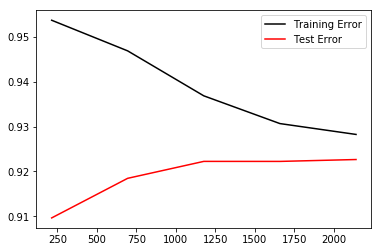

In [172]:
m, train_err, test_err = learning_curve(LR, X_train_scaled, y_train, cv = 10, scoring = 'accuracy', random_state = 42)
m_trainerr = np.mean(train_err, axis = 1)
m_testerr = np.mean(test_err, axis = 1)
plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
plt.legend(['Training Error', 'Test Error']);

In [160]:
base = np.round(np.mean(
            cross_val_score(LR, X_train_scaled, y_train, scoring = 'precision', cv = 10)), 5)
notuseful_cols = []
for i in X_train_scaled.columns:
    dummyX = deepcopy(X_train_scaled)
    dummycol = dummyX[i]
    dummyX = dummyX.drop(columns = i)
    np.random.seed(seed = 42)
    np.random.shuffle(dummycol)
    dummyX[i] = dummycol
    acc_cval = np.round(np.mean(
            cross_val_score(LR, dummyX, y_train, scoring = 'precision', cv = 10)), 5)
    delta = np.round(base - acc_cval, 5)
    if abs(delta) < 0.001:
        notuseful_cols.append(i)
    #print(f'Cval Precision Shuffle {i}: {acc_cval}')
    #print(f'Delta {i}: {delta}')

dummyX2 = deepcopy(X_train_scaled)
dummyX2.drop(columns = notuseful_cols, inplace = True)

In [161]:
LR_acc = np.round(np.mean(cross_val_score(LR, dummyX2, y_train, scoring = 'accuracy', cv = 10)), 5)
LR_pre = np.round(np.mean(cross_val_score(LR, dummyX2, y_train, scoring = 'precision', cv = 10)), 5)
print(f'The base LR accuracy is: {LR_acc}')
print(f'The base LR precision is: {LR_pre}')

The base LR accuracy is: 0.91552
The base LR precision is: 0.96409


In [162]:
[(i, j) for i, j in zip(dummyX2.columns, LR.coef_[0])]

[('pitchzone', -0.15563175028369658),
 ('hitterpitchcount', 0.22883170657208726),
 ('strikes', -0.21364221804600522),
 ('outs', -0.08160463363056049),
 ('homecurrenttotalruns', -0.04515372039595183),
 ('awaycurrenttotalruns', 0.2703095941818198),
 ('is_day', 0.0787307449793942),
 ('is_batterR', -1.211811817863262),
 ('is_rob1', 0.2369740699558883),
 ('is_rob2', 0.15891063164951477),
 ('is_FA', 0.023310994593968005),
 ('is_CU', -0.13542346025382532),
 ('is_CT', -1.4159921462456877)]

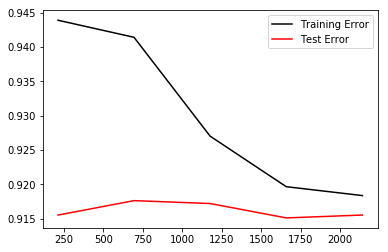

In [171]:
m, train_err, test_err = learning_curve(LR, dummyX2, y_train, cv = 10, scoring = 'accuracy', random_state = 42)
m_trainerr = np.mean(train_err, axis = 1)
m_testerr = np.mean(test_err, axis = 1)
plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
plt.legend(['Training Error', 'Test Error']);

0.9728608708818369

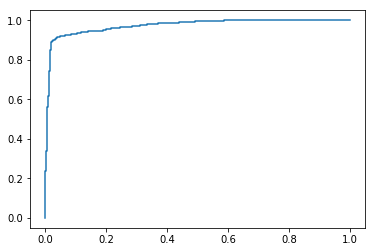

In [109]:
fpr, tpr, thr = roc_curve(y_train, y_predictprob)
plt.plot(fpr, tpr)
roc_auc_score(y_train, y_predictprob)

In [111]:
confusion_matrix(y_train, y_predict)

array([[ 593,   56],
       [ 123, 1607]])

https://cdn.vox-cdn.com/thumbor/EM3yroQxwmwa5faTVBM4mrtsYOY=/0x0:339x341/1200x0/filters:focal(0x0:339x341)/cdn.vox-cdn.com/uploads/chorus_asset/file/3374666/Strike_Zone.0.png
